In [1]:
import pickle

In [2]:
with open('../Data/allplayerFantasyGameLogs.pickle', 'rb') as handle:
  allplayerFantasyGameLogs = pickle.load(handle)

In [9]:
allplayerFantasyGameLogs.columns

Index([   u'GAME_DATE',    u'SEASON_ID',    u'Player_ID',      u'Game_ID',
            u'MATCHUP',           u'WL',          u'MIN',          u'FGM',
                u'FGA',       u'FG_PCT',         u'FG3M',         u'FG3A',
            u'FG3_PCT',          u'FTM',          u'FTA',       u'FT_PCT',
               u'OREB',         u'DREB',          u'REB',          u'AST',
                u'STL',          u'BLK',          u'TOV',           u'PF',
                u'PTS',   u'PLUS_MINUS',        u'DouBL',        u'TriBL',
             u'FanPTs',     u'fullName',    u'position1',         u'Team',
       u'OpponentTeam',     u'HomeGame'],
      dtype='object')

In [3]:
import pandas as pd

In [6]:
with open('../Data/PlayerFeaturesTable_02_29_2016.pickle', 'rb') as handle:
  PlayerFeaturesTable_02_29_2016 = pickle.load(handle)

In [7]:
PlayerFeaturesTable_02_29_2016.head()

,fullName,Player_ID,Team,position1,NumGames,AvgFanPTs,AvgPTS,AvgMIN,AvgFGM,AvgFGA,...,AvgSTL,AvgTOV,AvgPLUS_MINUS,NumDouBL,NumTriBL,Last3GameAvgFanPTs,Last6GameAvgFanPTs,Last3GameAvgMIN,Last3GameAvgPTS,Rank
0,Nate Robinson,101126,NOP,PG,2,4.000000,0.000000,11.500000,0.000000,0.500000,...,0.500000,0.000000,-10.000000,0,0,4.000000,4.000000,11.500000,0.000000,benchPlayer
1,Timofey Mozgov,202389,CLE,C,56,14.223214,6.357143,17.821429,2.732143,4.982143,...,0.285714,0.964286,0.214286,1,0,15.500000,17.750000,21.333333,7.666667,belowAvg
2,Alonzo Gee,202087,NOP,SF,58,11.012931,3.827586,21.448276,1.534483,3.172414,...,0.896552,0.637931,-2.517241,0,0,10.500000,7.583333,20.333333,4.333333,belowAvg
3,Steve Blake,2581,DET,PG,36,11.430556,4.277778,16.000000,1.527778,3.944444,...,0.416667,1.500000,-1.138889,0,0,12.750000,10.375000,16.333333,1.666667,belowAvg
4,Jimmy Butler,202710,CHI,SG,48,39.682292,22.375000,37.812500,7.437500,16.250000,...,1.687500,1.979167,0.187500,6,0,39.833333,39.125000,37.666667,21.333333,advanced


##Helper functions to do EDA and player-level feature extraction

###Function to aggregate statistics for each player up to a given game date

function to generate feature tables, namely training and testing data sets given a game date, where training data set contains all information before the predefined game date

In [34]:
def aggr_stats(date,allplayerFantasyGameLogs):
    interest_columns = ['fullName','Player_ID','Team','position1','MIN','PTS','FGM','FGA', 'FG3M','FG3A', \
                        'REB','AST','STL','TOV','PLUS_MINUS','DouBL','TriBL','FanPTs']
    tmp = allplayerFantasyGameLogs.ix['2015-10-27':date]
    
    playerID_tmp = tmp.reset_index().copy()
    tmp.grouped = playerID_tmp[interest_columns].groupby('Player_ID')
    
    def aggr(group):
        group['NumGames'] = group['fullName'].count()
        group['AvgFanPTs'] = group['FanPTs'].mean()
        group['AvgPTS'] = group['PTS'].mean()
        group['AvgMIN'] = group['MIN'].mean() 
        group['AvgFGM'] = group['FGM'].mean()
        group['AvgFGA'] = group['FGA'].mean()
        group['AvgFG3M'] = group['FG3M'].mean()
        group['AvgFG3A'] = group['FG3A'].mean()
        group['AvgREB'] = group['REB'].mean()
        group['AvgAST'] = group['AST'].mean()
        group['AvgSTL'] = group['STL'].mean()
        group['AvgTOV'] = group['TOV'].mean()
        group['AvgPLUS_MINUS'] = group['PLUS_MINUS'].mean()
        group['NumDouBL'] = group['DouBL'].sum()
        group['NumTriBL'] = group['TriBL'].sum()

        group['Last3GameAvgFanPTs'] = group['FanPTs'][:3].mean()
        group['Last6GameAvgFanPTs'] = group['FanPTs'][:6].mean()
        
        group['Last3GameAvgMIN'] = group['MIN'][:3].mean()
        group['Last3GameAvgPTS'] = group['PTS'][:3].mean()
        return group
    
    Newdf = tmp.grouped.apply(aggr)
    Newdf = Newdf.drop(['MIN','PTS','FGM','FGA', 'FG3M','FG3A','REB','AST','STL','TOV','PLUS_MINUS','DouBL','TriBL','FanPTs'],axis=1)
    Newdf.drop_duplicates(inplace=True)
    
    bins = [0, 10, 20, 30, 40, 100]
    group_names = ['benchPlayer','belowAvg','average','advanced','top']
    Newdf['Rank']= pd.cut(Newdf['AvgFanPTs'],bins,labels=group_names)
    return(Newdf)

In [38]:
PlayerFeaturesTable_02_29_2016 = aggr_stats('2016-2-29',allplayerFantasyGameLogs)

In [39]:
PlayerFeaturesTable_02_29_2016.shape

(495, 23)

In [40]:
PlayerFeaturesTable_02_29_2016[PlayerFeaturesTable_02_29_2016['Player_ID']==202710]

,fullName,Player_ID,Team,position1,NumGames,AvgFanPTs,AvgPTS,AvgMIN,AvgFGM,AvgFGA,...,AvgAST,AvgSTL,AvgTOV,AvgPLUS_MINUS,NumDouBL,NumTriBL,Last3GameAvgFanPTs,Last6GameAvgFanPTs,Last3GameAvgMIN,Last3GameAvgPTS
4,Jimmy Butler,202710,CHI,SG,48,39.682292,22.375,37.8125,7.4375,16.25,...,4.270833,1.6875,1.979167,0.1875,6,0,39.833333,39.125,37.666667,21.333333


In [55]:
with open('../Data/PlayerFeaturesTable_02_29_2016.pickle', 'wb') as handle:
  pickle.dump(PlayerFeaturesTable_02_29_2016,handle)

###Function to aggregate statistics summary for a team 

In [13]:
def playersummaryByTeam(team,PlayerFeaturesTable):
    tmp = PlayerFeaturesTable[PlayerFeaturesTable['Team']==team]
    return tmp

In [14]:
playersummaryByTeam('GSW',PlayerFeaturesTable_02_29_2016)

,fullName,Player_ID,Team,position1,NumGames,AvgFanPTs,AvgPTS,AvgMIN,AvgFGM,AvgFGA,AvgFG3M,AvgFG3A,AvgREB,AvgAST,AvgSTL,AvgTOV,AvgPLUS_MINUS,NumDouBL,NumTriBL
11,Klay Thompson,202691,GSW,SG,56,33.058036,21.785714,32.928571,7.928571,16.821429,3.196429,7.732143,3.696429,2.160714,0.714286,1.803571,12.107143,0,0
14,James Michael McAdoo,203949,GSW,PF,25,5.200000,2.280000,5.840000,0.880000,1.600000,0.000000,0.000000,1.280000,0.360000,0.280000,0.360000,-1.800000,0,0
17,Festus Ezeli,203105,GSW,C,40,19.050000,7.500000,17.725000,2.925000,5.250000,0.000000,0.000000,5.850000,0.775000,0.425000,0.900000,5.225000,6,0
19,Draymond Green,203110,GSW,SF,57,42.513158,13.754386,34.298246,4.859649,10.122807,1.228070,3.087719,9.666667,7.385965,1.421053,3.070175,13.964912,23,11
40,Stephen Curry,201939,GSW,PG,56,53.151786,30.678571,33.982143,10.303571,20.017857,5.142857,10.982143,5.285714,6.642857,2.107143,3.375000,14.267857,10,2
41,Andrew Bogut,101106,GSW,C,50,21.545000,5.360000,21.060000,2.520000,4.140000,0.000000,0.000000,7.300000,2.120000,0.400000,1.120000,5.420000,4,0
47,Brandon Rush,201575,GSW,SG,49,10.591837,4.530612,14.816327,1.632653,3.755102,0.938776,2.224490,2.612245,0.877551,0.326531,0.428571,-0.346939,0,0
48,Shaun Livingston,2733,GSW,PG,55,13.900000,6.163636,18.945455,2.600000,4.909091,0.036364,0.218182,1.890909,2.727273,0.618182,0.963636,1.527273,0,0
52,Marreese Speights,201578,GSW,C,48,12.333333,6.437500,11.145833,2.500000,6.208333,0.166667,0.500000,3.291667,0.729167,0.208333,0.937500,-1.208333,1,0
53,Leandro Barbosa,2571,GSW,SG,45,11.688889,6.288889,14.911111,2.511111,5.644444,0.533333,1.600000,1.466667,1.288889,0.755556,0.822222,0.044444,0,0


In [22]:
PlayerFeaturesTable_02_29_2016[(PlayerFeaturesTable_02_29_2016['Team']=='GSW') & (PlayerFeaturesTable_02_29_2016['position1']=='PG') ]

,fullName,Player_ID,Team,position1,NumGames,AvgFanPTs,AvgPTS,AvgMIN,AvgFGM,AvgFGA,AvgFG3M,AvgFG3A,AvgREB,AvgAST,AvgSTL,AvgTOV,AvgPLUS_MINUS,NumDouBL,NumTriBL
40,Stephen Curry,201939,GSW,PG,56,53.151786,30.678571,33.982143,10.303571,20.017857,5.142857,10.982143,5.285714,6.642857,2.107143,3.375000,14.267857,10,2
48,Shaun Livingston,2733,GSW,PG,55,13.900000,6.163636,18.945455,2.600000,4.909091,0.036364,0.218182,1.890909,2.727273,0.618182,0.963636,1.527273,0,0


###Functions to annotate player levels based on the average fantasey PTs

In [47]:
PlayerFeaturesTable_02_29_2016[(PlayerFeaturesTable_02_29_2016.AvgFanPTs>30) & (PlayerFeaturesTable_02_29_2016.AvgFanPTs<40)].shape

(45, 23)

Player levels: top( >40), advanced( >30), average(>20), belowAvg(>10), benchPlayer(<10)

In [50]:
bins = [0, 10, 20, 30, 40, 100]
group_names = ['benchPlayer','belowAvg','average','advanced','top']
PlayerFeaturesTable_02_29_2016['Rank']= pd.cut(PlayerFeaturesTable_02_29_2016['AvgFanPTs'],bins,labels=group_names)

In [56]:
PlayerFeaturesTable_02_29_2016[PlayerFeaturesTable_02_29_2016.Rank=='top'].sort_values(['AvgFanPTs'], ascending=False).head()

,fullName,Player_ID,Team,position1,NumGames,AvgFanPTs,AvgPTS,AvgMIN,AvgFGM,AvgFGA,...,AvgSTL,AvgTOV,AvgPLUS_MINUS,NumDouBL,NumTriBL,Last3GameAvgFanPTs,Last6GameAvgFanPTs,Last3GameAvgMIN,Last3GameAvgPTS,Rank
219,Russell Westbrook,201566,OKC,PG,60,54.112500,24.300000,34.566667,8.583333,18.550000,...,2.216667,4.166667,8.066667,41,9,58.166667,55.375,36.666667,32.000000,top
40,Stephen Curry,201939,GSW,PG,56,53.151786,30.678571,33.982143,10.303571,20.017857,...,2.107143,3.375000,14.267857,10,2,64.083333,59.500,33.000000,39.333333,top
108,DeMarcus Cousins,202326,SAC,C,49,51.505102,27.306122,34.510204,9.306122,20.836735,...,1.387755,3.857143,1.163265,35,1,41.916667,46.875,26.000000,22.000000,top
318,James Harden,201935,HOU,SG,60,50.995833,28.500000,37.600000,8.416667,19.400000,...,1.650000,4.466667,-0.133333,15,2,40.083333,48.875,37.333333,18.000000,top
199,Kevin Durant,201142,OKC,SF,53,49.650943,27.905660,36.075472,9.622642,18.981132,...,0.962264,3.207547,8.735849,20,1,45.500000,46.375,39.000000,30.000000,top


###Function to generate a score(PTS) leader board given a game date
the same applies to other attributes, such as 'REB', 'AST', 'FG3', 'BLK', 'PLUS_MINUS'

In [15]:
def get_leader_board(attr, date):
    tmp = allplayerFantasyGameLogs.ix['10/27/2015':date]
    tmp = tmp[['fullName',attr]].reset_index().groupby('fullName').mean()
    result_df = tmp.sort_values([attr], ascending=False)

    return(result_df)

In [16]:
#Test 1. leader board for scoring
test1 = get_leader_board('PTS','2/29/2016')
test1.head()

,PTS
fullName,
Stephen Curry,30.678571
James Harden,28.500000
Kevin Durant,27.905660
DeMarcus Cousins,27.306122
Damian Lillard,25.358491


In [14]:
#Test 2. leader board for Fantasy Points
get_leader_board('FanPTs','2/29/2016').head(10)

,FanPTs
fullName,
Russell Westbrook,54.112500
Stephen Curry,53.151786
DeMarcus Cousins,51.505102
James Harden,50.995833
Kevin Durant,49.650943
LeBron James,47.350877
Anthony Davis,46.799020
John Wall,46.105932
Damian Lillard,44.198113


In [15]:
#Test 3. leader board for Fantasy Points
get_leader_board('PLUS_MINUS','2/29/2016').head(10)

,PLUS_MINUS
fullName,
Stephen Curry,14.267857
Draymond Green,13.964912
Klay Thompson,12.107143
Kawhi Leonard,9.685185
Jorge Gutierrez,9.000000
Kevin Durant,8.735849
Michael Kidd-Gilchrist,8.285714
Tim Duncan,8.113636
Russell Westbrook,8.066667


#Function to extract team-level features

We can get team-level features by aggregating the information from the player game logs. We want to get format like http://www.rotowire.com/daily/nba/defense-vspos.htm?site=DraftKings . 
We will store the information as a pivot table:

In [1]:
def aggr_teamVSteam(group):
        group['TeamStdVSFanPTs'] = group['FanPTs'].std()
        group['TeamAvgVSFanPTs'] = group['FanPTs'].mean()
        group['TeamMaxVSFanPTs'] = group['FanPTs'].max()
        return group

def aggr_team(group):
        group['TeamStdFanPTs'] = group['TeamStdVSFanPTs'].mean()
        group['TeamAvgFanPTs'] = group['TeamAvgVSFanPTs'].mean()
        group['TeamMaxFanPTs'] = group['TeamMaxVSFanPTs'].mean()
        return group    

def generate_team_features(playerGameLogs, playerFeatureTable, date):
    tmp = playerGameLogs['2015-10-27': date]
    tmp = tmp.reset_index()
    bad_players = playerFeatureTable[playerFeatureTable.Rank=='benchPlayer']['Player_ID']
    interest_cols = ['fullName','Player_ID','Team','OpponentTeam','position1','FanPTs','MIN']
    tmp = tmp[interest_cols]
    tmp = tmp[~tmp['Player_ID'].isin(bad_players)]
    
    newdf = tmp.copy()
    newdf_grouped = newdf.groupby(['Team','OpponentTeam'])
        
    Newdf = newdf_grouped.apply(aggr_teamVSteam)
    Newdf.drop(['fullName','Player_ID','MIN','FanPTs','position1'],inplace=True,axis=1)
    Newdf.drop_duplicates(['Team','OpponentTeam'],inplace=True)
    
    Newdf.drop('OpponentTeam',axis=1,inplace=True)
    
    Newdf2 = Newdf.copy()
    Newdf2_grouped = Newdf2.groupby('Team')
    
    Newdf_overall = Newdf2_grouped.apply(aggr_team)
    Newdf_overall.drop(['TeamStdVSFanPTs','TeamAvgVSFanPTs','TeamMaxVSFanPTs'],inplace=True,axis=1)
    Newdf_overall.drop_duplicates('Team',inplace=True)
    
    return(Newdf_overall)

In [8]:
TeamFeaturesTable_02_29_2016 = generate_team_features(allplayerFantasyGameLogs, PlayerFeaturesTable_02_29_2016, '2016-2-29')

In [12]:
TeamFeaturesTable_02_29_2016.sort_values('TeamAvgFanPTs',ascending=False).head(10)

,Team,TeamStdFanPTs,TeamAvgFanPTs,TeamMaxFanPTs
112,MIL,11.728469,27.335076,47.775862
89,OKC,18.041447,26.337636,61.896552
86,SAC,15.575331,26.193151,58.784483
80,WAS,13.724262,24.812745,54.250000
11,GSW,16.866041,24.661798,62.724138
1,CLE,14.490258,24.289754,52.758621
7,ATL,12.813778,23.988525,48.689655
78,IND,12.498657,23.831644,50.310345
85,BOS,12.250411,23.452908,46.705357
76,MIA,12.925946,23.448114,48.370690


In [201]:
with open('../Data/TeamFeaturesTable_02_29_2016.pickle', 'wb') as handle:
  pickle.dump(TeamFeaturesTable_02_29_2016,handle)

#Visualization

In [4]:
import seaborn as sns
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


function to plot the trend of certain statistics for a player

In [18]:
from ggplot import *

In [146]:
def plot_trend(players, stat): #players should be a list   
    tmp = allplayerFantasyGameLogs[allplayerFantasyGameLogs["fullName"].isin(players)][['fullName',stat]].reset_index()
    plot_obj = ggplot(aes(x='GAME_DATE', y=stat, colour='fullName'), data=tmp) + geom_line() \
+ ggtitle("Stats For Players")+theme(axis_text_x  = element_text(angle = 60, hjust = 1))
    return(plot_obj)

In [141]:
#ggsave('test_plot.png',test, device='png',width=10, height=10)

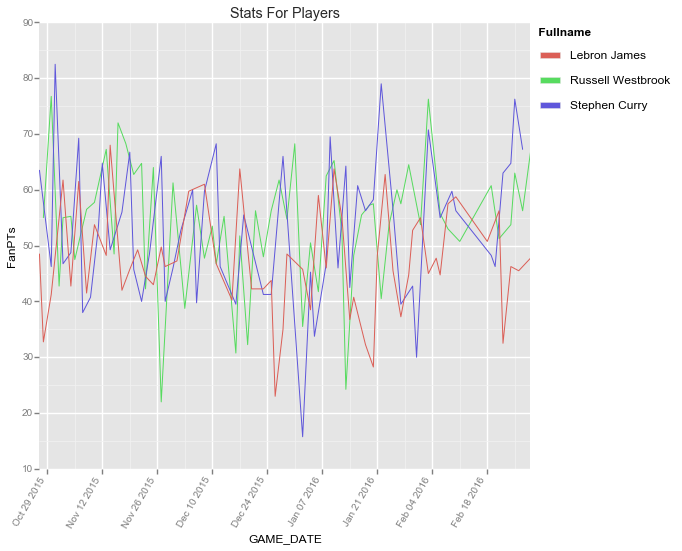

<ggplot: (275031889)>

In [134]:
plot_trend(["Stephen Curry","Russell Westbrook","LeBron James"], "FanPTs")

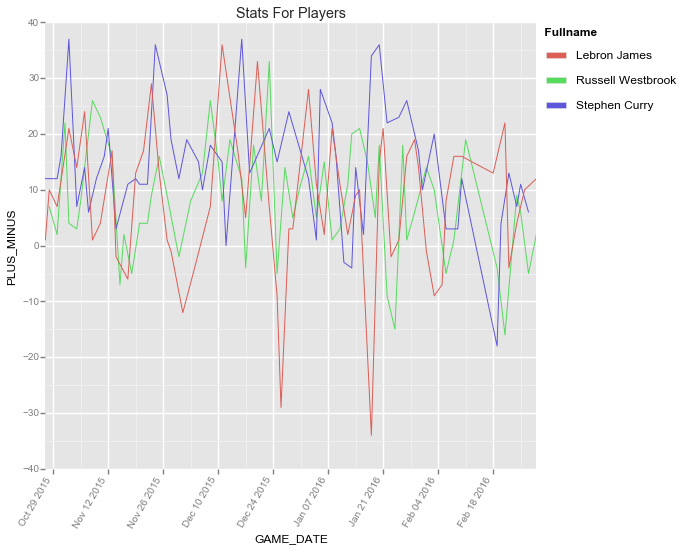

<ggplot: (283317365)>

In [147]:
plot_trend(["Stephen Curry","Russell Westbrook","LeBron James"], "PLUS_MINUS")

###function to plot relationship between two attributes 

1. split by class.
2. with annotation for top players

In [74]:
def plot_relationship(stat1, stat2, PlayerFeaturesTable, **kwargs):    
    by_stat = kwargs.get('by', None)
    
    #tmp = PlayerFeaturesTable[allplayerFantasyGameLogs["fullName"].isin(players)][['fullName',stat]].reset_index()
    if by_stat==None:
        plot_obj = ggplot(aes(x=stat1, y=stat2), data=PlayerFeaturesTable) + geom_point() \
+ ggtitle(stat1 + '  V.S  ' + stat2)
    else:
        plot_obj = ggplot(aes(x=stat1, y=stat2, color=by_stat), data=PlayerFeaturesTable) + geom_point() \
+ ggtitle(stat1 + '  V.S  ' + stat2)
    return(plot_obj)

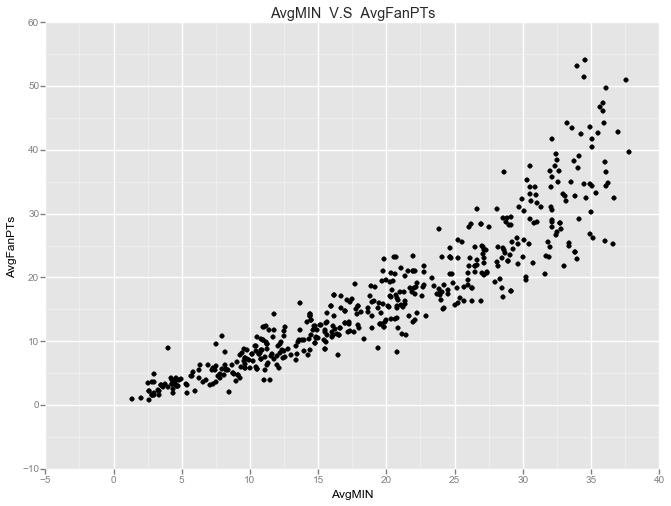

<ggplot: (284828349)>

In [75]:
plot_relationship('AvgMIN','AvgFanPTs',PlayerFeaturesTable_02_29_2016)

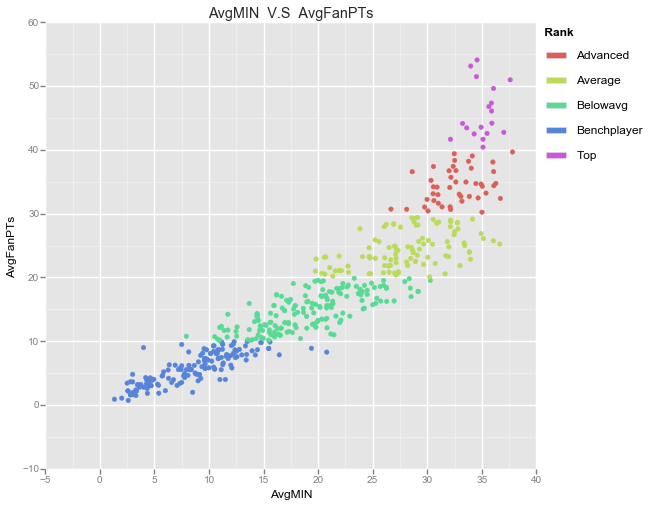

<ggplot: (283243097)>

In [77]:
plot_relationship('AvgMIN','AvgFanPTs',PlayerFeaturesTable_02_29_2016,by='Rank')

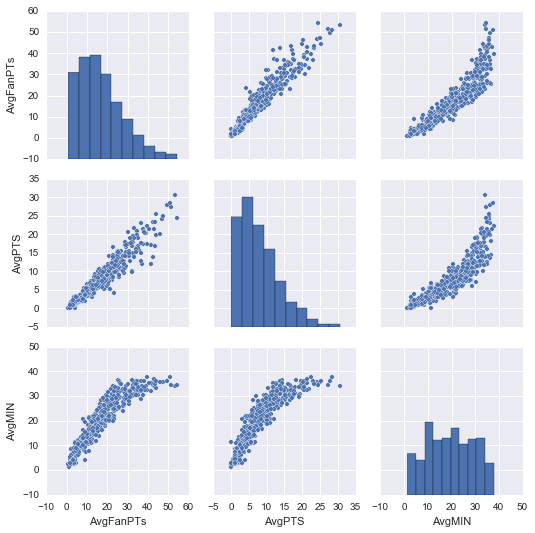

In [9]:
sns.pairplot(PlayerFeaturesTable_02_29_2016[["AvgFanPTs", "AvgPTS", "AvgMIN"]])
#plt.show()

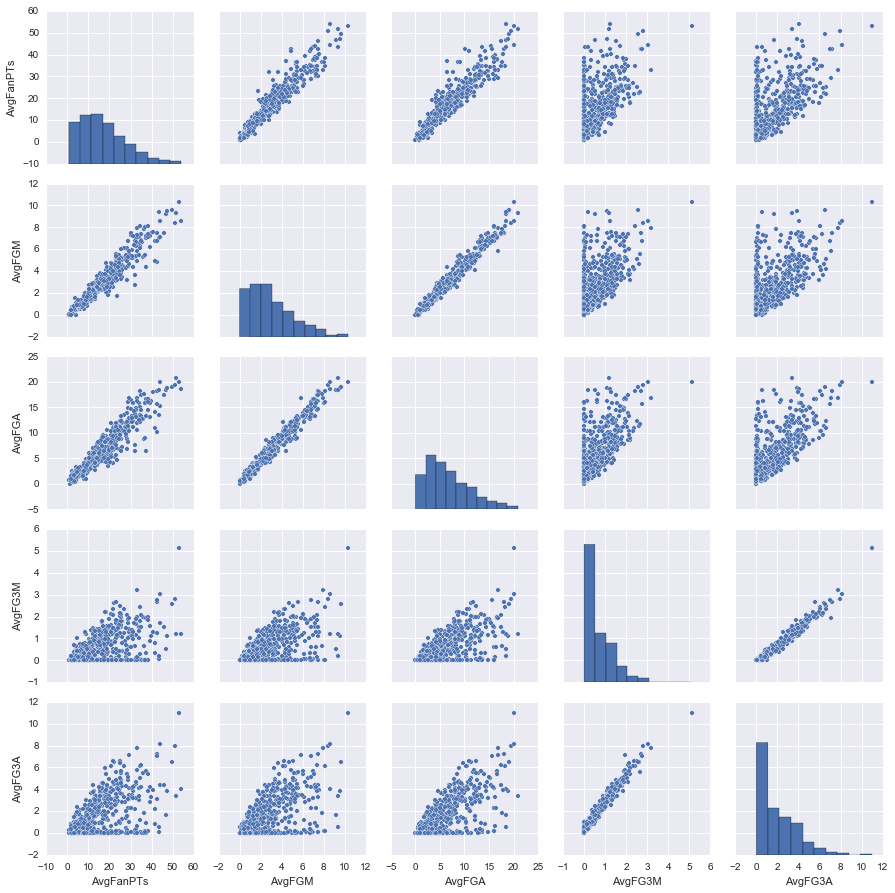

In [10]:
sns.pairplot(PlayerFeaturesTable_02_29_2016[["AvgFanPTs",'AvgFGM',"AvgFGA","AvgFG3M","AvgFG3A"]])

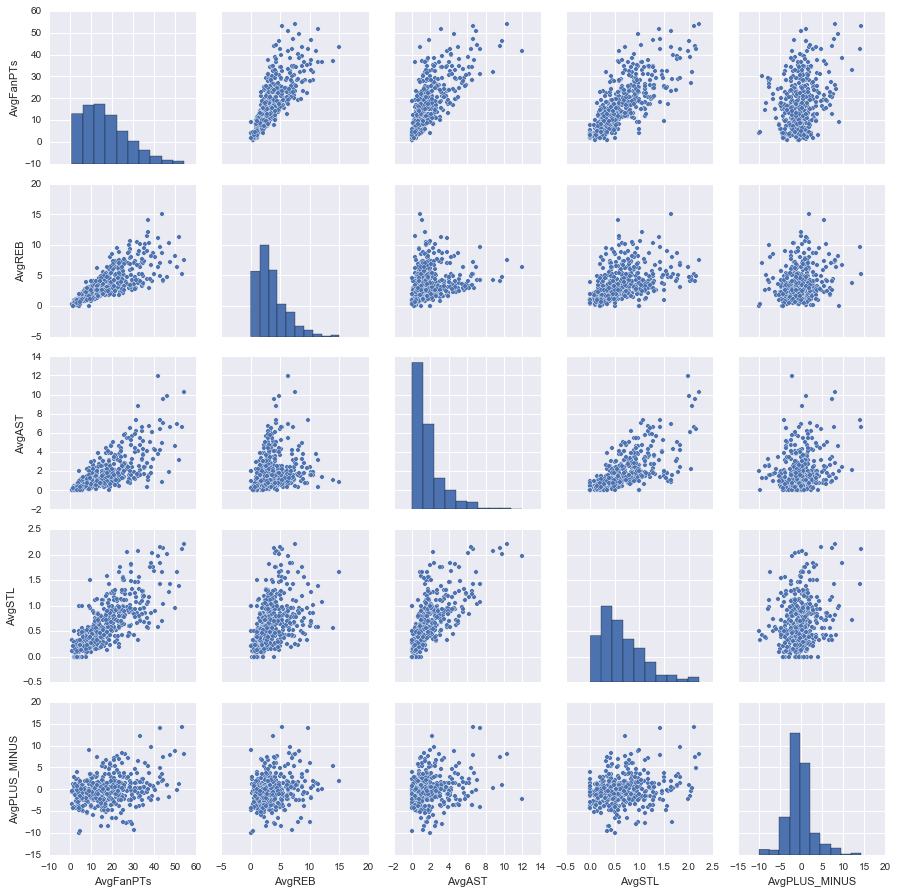

In [11]:
sns.pairplot(PlayerFeaturesTable_02_29_2016[["AvgFanPTs",'AvgREB','AvgAST','AvgSTL','AvgPLUS_MINUS']])